# Подключение Google Drive и библиотек

In [1]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=cbe2131d103c929a269e165a13a3139ac38342bc191cffe48976c4b1b0261e40
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torch import nn
from torch import optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report

from matplotlib import pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from pymorphy2 import MorphAnalyzer

from collections import defaultdict

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Определение инструментальных параметров

In [5]:
DATA_PATH = '/content/drive/MyDrive/datasets/ready2020.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Прикладные функции

## Обработка данных

In [6]:
def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
  data = data.loc[:, ['text', 'stars']].rename(columns={
        'text': 'data',
        'stars': 'target'
    })
  data = data.dropna().reset_index(drop=True)
  data['target'] = data['target'].replace({0.0: 0, 1.0: 0, 3.0: 1, 4.0: 1, 5.0: 2})
  return data

def balance_data(data: pd.DataFrame, repetitions: int = 2) -> pd.DataFrame:
  return pd.concat((data, *([data[data['target'] != 2]] * repetitions))).sample(frac=1).reset_index(drop=True)

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
  data['data'] = data['data'].str.lower().replace(r'[^а-я]', ' ', regex=True)
  morph_analyzer = MorphAnalyzer()
  stop_words = stopwords.words('russian')
  data['data'] = data['data'].map(lambda x: lemmatize(x, morph_analyzer, stop_words))
  return data

def lemmatize(data: str, morph_analyzer: MorphAnalyzer, stop_words: list[str]) -> str:
  result = []
  for word in word_tokenize(data):
    word = morph_analyzer.parse(word)[0]
    if word.is_known and word.normal_form not in stop_words:
      result.append(word.normal_form)
  return ' '.join(result)



## Метрики и графики

In [57]:
def show_balance(datas: tuple[pd.Series], labels: tuple[str]) -> None:
  plt.title('Распределение данных по группам')
  for data, label in zip(datas, labels):
    plt.hist(data, bins=3, label=label, rwidth=0.9)
  plt.ylabel('Кол-во данных в группе')
  plt.xlabel('Группа')
  plt.xticks((0.33, 1, 1.66), ('Негативные', 'Нейтральные', 'Позитивные'))
  plt.legend()

def metrics(nn_true: torch.Tensor, nn_pred: torch.Tensor, dict_true: pd.Series, dict_pred: pd.Series) -> pd.DataFrame:
  df = pd.DataFrame([], index=['balanced_accuracy'], columns=['NN', 'Dict'])
  
  df.loc['balanced_accuracy', ['NN', 'Dict']] = (balanced_accuracy_score(nn_true, nn_pred), balanced_accuracy_score(dict_true, dict_pred))
  
  nn_report = classification_report(
      y_true=nn_true,
      y_pred=nn_pred,
      target_names=['Плохие', 'Нейтральные', 'Хорошие'],
      zero_division=0
  )

  dict_report = classification_report(
      y_true=dict_true,
      y_pred=dict_pred,
      target_names=['Плохие', 'Нейтральные', 'Хорошие'],
      zero_division=0
  )

  return df, nn_report, dict_report

## Обучение и тестирование нейронной сети

In [8]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: _Loss, optimizer: optim.Optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    pred = model(X)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 10 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Описание задачи и набора данных

In [9]:
data = pd.read_csv('/content/drive/MyDrive/datasets/ready2020.csv', delimiter=';', index_col=0)
data

,date,name,stars,text,X,Y,status
1,29 марта 2020,ЯНатка,2.0,Были на экскурсии. Я очень люблю производствен...,37.599740,55.815575,Открыто до 20:00
2,21 марта 2020,Анна М.,5.0,"Часто ходим в это кафе. Красивый интерьер, оче...",37.599740,55.815575,Открыто до 20:00
3,28 декабря 2020,Фима,5.0,Вкусное мороженое. С кофе и яблочным пирогом с...,37.599740,55.815575,Открыто до 20:00
4,28 июня 2020,Игорь Юдин,5.0,"Хорошее мороженное, разнообразие выбора и вкус...",37.599740,55.815575,Открыто до 20:00
5,28 ноября 2020,Ольга -.,1.0,Ставлю одну звезду лишь за вкусное мороженое. ...,37.599740,55.815575,Открыто до 20:00
...,...,...,...,...,...,...,...
103909,9 марта 2020,Иван Кузнецов,1.0,"Зашли покурить кальян, попить чаю. Заказали ка...",37.593007,55.750032,Больше не работает
103910,27 сентября 2020,Мария З.,4.0,"Мне понравилось. Быстро подошла официантка, бы...",37.593007,55.750032,Больше не работает
103911,12 октября 2020,Валерия Л.,5.0,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил...",37.593007,55.750032,Больше не работает
103912,26 августа 2020,эрик моралес,5.0,"Госпади, как же тут вкусно готовят из простых ...",37.593007,55.750032,Больше не работает


In [10]:
data.shape

(103913, 7)

In [11]:
data.isna().sum()

date       0
name       0
stars     40
text       0
X         53
Y         15
status     0
dtype: int64

<Axes: >

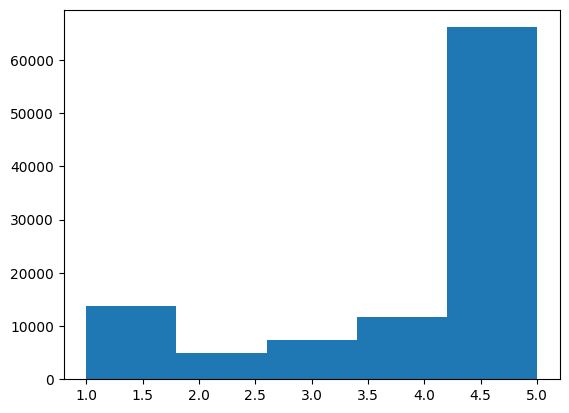

In [12]:
data['stars'].hist(bins=5, grid=False)

Набор данных представляет из себя множество пользовательских отзывов к разным кафе.

Набор данных состоит из следующих полей:

*   date. Дата создания отзыва
*   name. Имя пользователя, написавшего отзыв
*   stars. Количество звезд, поставленных пользователем
*   text. Текст отзыва
*   X и Y. Координаты кафе, к которому был оставлен отзыв
*   status. Статус кафе, к которому был оставлен отзыв

В наборе данных около 100 000 отзывов. Сами отзывы сильно несбалансированы: 5-звездочных в разы больше, чем все остальных.

В наборе присутствуют пропущенные значения. Однако так как их мало относительно общего количества отзывов, их можно без вреда убрать из набора данных.



Задачей работы является множественная классификация текстов. Поэтому из всех полей необходимы только два: сам текст отзыва и количество звезд, поставленных в этом отзыве.

В работе будут рассмотрены два подхода к классификации текстов:

*   Тональный анализ текстов с помощью соотвествующих словарей.
*   Тональный анализ текстов с помощью инструментов машинного обучения.

Так как в большинстве словарей поддерживаются разделения слов на ограниченное количество групп (обычно это положительная, нейтральная, отрицательная и неопределенная группы), будет рациональнее объединить отзывы в группы по следующему принципу:

*   Если отзыв имеет 5 звезд, он относится к положительным отзывам.
*   Если отзыв имеет 3 или 4 звезды, он относится к нейтральным отзывам.
*   Если отзыв имеет 1 или 2 звезды, он относится к отрицательным отзывам.

Так как нейронный сети не умеют работать с категориальными данными, группы будут обозначены следующим образом:

*   Положительные отзывы - 2
*   Нейтральные отзывы - 1
*   Отрицательные отзывы - 0





In [13]:
data = prepare_data(data=data)
data

,data,target
0,Были на экскурсии. Я очень люблю производствен...,2.0
1,"Часто ходим в это кафе. Красивый интерьер, оче...",2.0
2,Вкусное мороженое. С кофе и яблочным пирогом с...,2.0
3,"Хорошее мороженное, разнообразие выбора и вкус...",2.0
4,Ставлю одну звезду лишь за вкусное мороженое. ...,0.0
...,...,...
103868,"Зашли покурить кальян, попить чаю. Заказали ка...",0.0
103869,"Мне понравилось. Быстро подошла официантка, бы...",1.0
103870,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил...",2.0
103871,"Госпади, как же тут вкусно готовят из простых ...",2.0


Для предобработки данных будут выполнены следующие действия:

1.   Приведение всех строк к нижнему регистру и удаление всех символов, неотносящихся к кириллице. 
2.   Удаление стоп-слов.
3.   Лемматизация слов.



In [14]:
data = preprocess_data(data)
data

,data,target
0,экскурсия очень любить производственный экскур...,2.0
1,часто ходить это кафе красивый интерьер очень ...,2.0
2,вкусный мороженое кофе яблочный пирог мятый об...,2.0
3,хороший мороженный разнообразие выбор вкус веж...,2.0
4,ставить звезда лишь вкусный мороженое отсутств...,0.0
...,...,...
103868,заслать покурить кальян попить чай заказать ка...,0.0
103869,понравиться быстро подойти официантка быстро п...,1.0
103870,очень вкусно турецкий атмосфера всё понравитьс...,2.0
103871,вкусно готовить простой продукт,2.0


In [ ]:
data.to_csv('/content/drive/MyDrive/datasets/ready2020_lemmatized.csv')

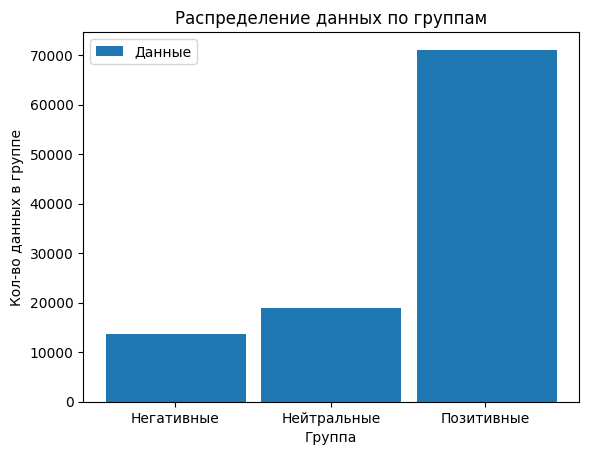

In [15]:
show_balance((data['target'], ), ('Данные', ))

Так как данные в наборе после перегруппировки остались несбалансированными, это может повлиять на эффективность обучения нейронной сети. Для снижения несбалансированности применяется метод пересэмплинга - дуплицирование редковстречающихся категорий сэмплов.

Такие сэмплы дублируются два раза, в результате чего данные становятся более сбалансированными.

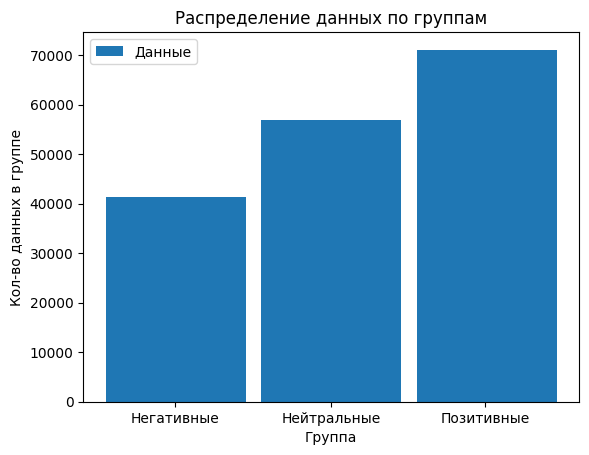

In [16]:
data = balance_data(data)
show_balance((data['target'], ), ('Данные', ))

В качестве показателей эффективности будут использоваться следующие метрики:

*   Accracy.
*   Precision.
*   Recall.
*   F1.

# Определение тональности с помощью машинного обучения

## Параметры

In [17]:
NUM_BATCHES = 75

## Подготовка данных

Для обработки текстовых данных в нейронной сети необходимо провести его векторизацию и создать на их основе DataLoader-ы.

In [18]:
class Vocab:

  PAD = '<PAD>'
  UNK = '<UNK>'

  def __init__(self, data: pd.Series) -> None:
    words = set()
    max_length = 0
    for row in data:
      words.update([word for word in word_tokenize(row)])
      max_length = max(max_length, len(word_tokenize(row)))
    self.max_length = max_length
    self.tokens = [self.PAD, self.UNK] + list(words)
    self.word2vec = defaultdict(lambda: 1, {word: i for i, word in enumerate(self.tokens)})
  
  def __len__(self) -> int:
    return len(self.tokens)

  def vectorize(self, text) -> torch.Tensor:
    vector = torch.zeros(self.max_length)
    for i, word in enumerate(word_tokenize(text)):
      vector[i] = self.word2vec[word]
    return vector

In [19]:
vocab = Vocab(data['data'])
len(vocab), vocab.max_length

(26345, 760)

In [20]:
class ReviewDataset(Dataset):

  def __init__(self, X: pd.Series, y: pd.Series, vocab: Vocab) -> None:
    self.X = torch.vstack(X.map(vocab.vectorize).tolist()).to(torch.long)
    self.y = torch.tensor(y.tolist(), dtype=torch.long)

  def __len__(self) -> int:
    return len(self.X)

  def __getitem__(self, index) -> tuple[torch.Tensor, torch.long]:
    return self.X[index], self.y[index]

Данные будут разбиты на две части: обучающую и тестовую, в соотношениях 4 к 1 соотвественно.

In [21]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True)
train_data.shape, test_data.shape

((135492, 2), (33873, 2))

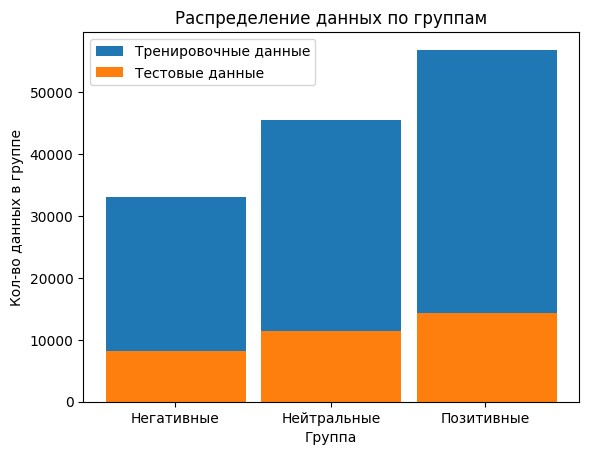

In [22]:
show_balance((train_data['target'], test_data['target']), ('Тренировочные данные', 'Тестовые данные'))

In [23]:
train_dataset = ReviewDataset(train_data['data'], train_data['target'].astype(int), vocab)
test_dataset = ReviewDataset(test_data['data'], test_data['target'].astype(int), vocab)

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset)//NUM_BATCHES, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=train_dataloader.batch_size, drop_last=True)

## Модель и гиперпараметры

In [25]:
LR = 0.001
EPOCHS = 25
DROP_PROBABILITY = 0.1
EMBEDDING_DIM = 256
HIDDEN_SIZE = 16
NUM_LAYERS = 3

In [26]:
class NeuralNetwork(nn.Module):

  def __init__(
      self, 
      num_embedding: int, 
      embedding_dim: int, 
      hidden_size: int, 
      vector_length: int, 
      num_layers: int, 
      out_features: int) -> None:

    super().__init__()

    self.embedding = nn.Embedding(num_embeddings=num_embedding, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_size*vector_length, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=DROP_PROBABILITY),
        nn.Linear(in_features=256, out_features=out_features),
        nn.Softmax(dim=1)
    )

    self.h_x = None
    self.c_x = None
    
  def forward(self, inputs: torch.Tensor) -> torch.Tensor:
    if self.h_x is not None and self.c_x is not None:
      h_c = (self.h_x, self.c_x)
    else:
      h_c = None
    inputs = self.embedding(inputs)
    inputs, (h_x, c_x) = self.lstm(inputs, h_c)
    self.h_x = h_x.detach()
    self.c_x = c_x.detach()
    inputs = self.classifier(inputs)
    return inputs

In [41]:
torch.cuda.empty_cache()
import gc
gc.collect()

376

In [42]:
net = NeuralNetwork(
    num_embedding=len(vocab), 
    embedding_dim=EMBEDDING_DIM, 
    hidden_size=HIDDEN_SIZE, 
    vector_length=vocab.max_length, 
    num_layers=NUM_LAYERS, 
    out_features=3
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)
net

NeuralNetwork(
  (embedding): Embedding(26345, 256)
  (lstm): LSTM(256, 16, batch_first=True)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12160, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [43]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    test_loop(test_dataloader, net, loss_fn)

Epoch 1
-------------------------------
loss: 1.095435  [ 1806/135492]
loss: 1.224202  [19866/135492]
loss: 1.234722  [37926/135492]
loss: 1.212574  [55986/135492]
loss: 1.209800  [74046/135492]
loss: 1.088657  [92106/135492]
loss: 1.049549  [110166/135492]
loss: 0.999375  [128226/135492]
Test Error: 
 Accuracy: 55.0%, Avg loss: 0.964826 

Epoch 2
-------------------------------
loss: 0.948478  [ 1806/135492]
loss: 0.924204  [19866/135492]
loss: 0.905566  [37926/135492]
loss: 0.877561  [55986/135492]
loss: 0.863376  [74046/135492]
loss: 0.852771  [92106/135492]
loss: 0.847811  [110166/135492]
loss: 0.826854  [128226/135492]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.830317 

Epoch 3
-------------------------------
loss: 0.814433  [ 1806/135492]
loss: 0.798989  [19866/135492]
loss: 0.787137  [37926/135492]
loss: 0.773453  [55986/135492]
loss: 0.780837  [74046/135492]
loss: 0.788846  [92106/135492]
loss: 0.778667  [110166/135492]
loss: 0.769428  [128226/135492]
Test Error: 
 Accuracy: 72

In [44]:
torch.save(net.state_dict(), '/content/drive/MyDrive/models/lstm/net.pth')

# Определение тональности с помощью тонального словаря

## Параметры

In [28]:
DICTIONARY_PATH = '/content/drive/MyDrive/datasets/kartaslovsent.csv'

## Подготовка данных

In [29]:
dictionary = pd.read_csv(DICTIONARY_PATH, delimiter=';').set_index('term')
dictionary

,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
term,,,,,,,
абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19
...,...,...,...,...,...,...,...
ёмкость,NEUT,0.00,0.167,0.000,0.690,0.143,0.00
ёрзать,NGTV,-0.54,0.050,0.446,0.397,0.107,0.00
ёрничать,NGTV,-0.79,0.078,0.529,0.236,0.157,0.00


In [70]:
MIXED_THRESHOLD = 0.223
NEGATIVE_THRESHOLD = 0.1

def calculate_tonalty(text: str, tags: pd.Series) -> float:
  count_positive = 0
  count_neutral = 0
  count_negative = 0
  for word in word_tokenize(text):
    if word in tags:
      tag = tags[word]
      if tag == 'PSTV':
        count_positive += 1
      elif tag == 'NEUT':
        count_neutral += 1
      elif tag == 'NGTV':
        count_negative += 1
  total_count = count_positive + count_neutral + count_negative
  if total_count == 0:
    return 2.0
  count_positive /= total_count
  count_negative /= total_count
  if abs(count_positive - count_negative) < MIXED_THRESHOLD:
    return 1.0
  elif count_negative > NEGATIVE_THRESHOLD:
    return 0.0
  else:
    return 2.0

In [71]:
data_with_tonalty = data.copy(deep=True)
data_with_tonalty['tonalty'] = data_with_tonalty['data'].map(lambda x: calculate_tonalty(x, dictionary['tag']))
data_with_tonalty

,data,target,tonalty
0,вс очень вкусно большой выбор классный чай нем...,1.0,1.0
1,всё супер,2.0,2.0
2,нормальный еда нормальный цена недовольный ниж...,2.0,2.0
3,сегодня ждать свой поезд прийтись полтора час ...,1.0,1.0
4,всё круто персонал добрый цена слегка кусать э...,2.0,1.0
...,...,...,...
169360,это просто окно выдача парковка машина оставит...,0.0,1.0
169361,очень достойный место семейный посещение весь ...,2.0,2.0
169362,приятный место хороший кальян еда вкусный,1.0,0.0
169363,вкусно быстрый доставка пробовать ролл морс,1.0,1.0


# Загрузка данных для расчета метрик

In [33]:
data_dataset = ReviewDataset(data['data'], data['target'].astype(int), vocab)

In [34]:
data_dataloader = DataLoader(data_dataset, batch_size=train_dataloader.batch_size, shuffle=True, drop_last=True)

In [36]:
net.load_state_dict(torch.load('/content/drive/MyDrive/models/lstm/net.pt'))
net.eval()

NeuralNetwork(
  (embedding): Embedding(26345, 256)
  (lstm): LSTM(256, 16, batch_first=True)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12160, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [45]:
nn_pred = []
nn_true = []
with torch.no_grad():
  for X, y in data_dataloader:
    nn_true.append(y)
    X, y = X.to(DEVICE), y.to(DEVICE)
    pred = net(X)
    nn_pred.append(pred.cpu().detach().argmax(1))
nn_pred = torch.cat(nn_pred)
nn_true = torch.cat(nn_true)

# Метрики

In [73]:
accuracy_scores, nn_report, dict_report = metrics(nn_true, nn_pred, data_with_tonalty['target'], data_with_tonalty['tonalty'])

In [74]:
accuracy_scores

,NN,Dict
balanced_accuracy,0.875287,0.456168


In [75]:
print(nn_report)

              precision    recall  f1-score   support

      Плохие       0.88      0.91      0.90     40986
 Нейтральные       0.86      0.83      0.85     56451
     Хорошие       0.88      0.88      0.88     70521

    accuracy                           0.87    167958
   macro avg       0.87      0.88      0.87    167958
weighted avg       0.87      0.87      0.87    167958



In [76]:
print(dict_report)

              precision    recall  f1-score   support

      Плохие       0.43      0.09      0.15     41322
 Нейтральные       0.38      0.54      0.45     56916
     Хорошие       0.66      0.74      0.69     71127

    accuracy                           0.51    169365
   macro avg       0.49      0.46      0.43    169365
weighted avg       0.51      0.51      0.48    169365

